# Single agent version


In [ ]:
from src.evals.human_verified_searches import (
    EDMONTON_HUMAN_NUTRITION_RESEARCH_UNIT__VERY_NARROW_SCOPE,
)
from src.evals.eval_runner import test_correctness_with_visual_comparison
from src.agents.single_agent_pattern import run_single_agent
from rich import print as rprint


results = await test_correctness_with_visual_comparison(
    call_agent=run_single_agent,
    eval_params=EDMONTON_HUMAN_NUTRITION_RESEARCH_UNIT__VERY_NARROW_SCOPE,
    n_results_search=20,
)

In [ ]:
from src.evals.human_verified_searches import EDMONTON_ALES_RESEARCHERS__MID_BROAD_SCOPE
from src.evals.eval_runner import test_correctness_with_visual_comparison
from src.agents.single_agent_pattern import run_single_agent
from rich import print as rprint


results = await test_correctness_with_visual_comparison(
    call_agent=run_single_agent,
    eval_params=EDMONTON_ALES_RESEARCHERS__MID_BROAD_SCOPE,
    n_results_search=20,
)

### Observations:

- [ ] Models allucinate a lot of information on the lack more details (example: sees a name on a article but can't find the person inforamtion, it then allucinate their contact info)
- [ ] The search paths are very narrow and and can totally get out of path when faced with some timeout or other types of page retrieval errors.
- [ ] Even though many parallel calls are made the explorations paths are still not enough to cover possibilities.
- [ ] There is an important need to have a fact check phase. The model tends to ignore important filtering cases like WHERE and CONTEXT clausese. This normally happens when models expand search and then the filters get "lost" in their context or attention


# Multi agent version


In [ ]:
from src.evals.human_verified_searches import (
    EDMONTON_HUMAN_NUTRITION_RESEARCH_UNIT__VERY_NARROW_SCOPE,
)
from src.evals.eval_runner import test_correctness_with_visual_comparison
from src.agents.multi_agent_pattern import run_multi_agent


results = await test_correctness_with_visual_comparison(
    call_agent=run_multi_agent,
    eval_params=EDMONTON_HUMAN_NUTRITION_RESEARCH_UNIT__VERY_NARROW_SCOPE,
    n_results_search=20,
)

In [ ]:
from src.evals.human_verified_searches import EDMONTON_ALES_RESEARCHERS__MID_BROAD_SCOPE
from src.evals.eval_runner import test_correctness_with_visual_comparison
from src.agents.multi_agent_pattern import run_multi_agent


results = await test_correctness_with_visual_comparison(
    call_agent=run_multi_agent,
    eval_params=EDMONTON_ALES_RESEARCHERS__MID_BROAD_SCOPE,
    n_results_search=20,
    orchestrator_model="openai:gpt-4.1",
    researcher_model="openai:gpt-4.1-mini-2025-04-14",
)

# Generating Report


#### Single Agent


In [ ]:
from src.evals.human_verified_searches import (
    EDMONTON_HUMAN_NUTRITION_RESEARCH_UNIT__VERY_NARROW_SCOPE,
    EDMONTON_ALES_RESEARCHERS__MID_BROAD_SCOPE,
)
from src.evals.eval_runner import test_correctness_with_visual_comparison
from src.agents.single_agent_pattern import run_single_agent
import pandas as pd
import os
import re

N_RESULTS_PER_SEARCH = 10

models = [
    "openai:gpt-4.1",
    "openai:gpt-4.1-mini-2025-04-14",
    "openai:gpt-4.1-nano-2025-04-14",
    "anthropic:claude-sonnet-4-20250514",
    "anthropic:claude-3-7-sonnet-latest",
    "anthropic:claude-3-5-sonnet-latest",
]

single_agent_results = []

for i, model in enumerate(models):
    print(f"Running model {model} for checkpoint {i}")
    # Check if model is in the latest checkpoint in ./checkpoints, skip if so

    checkpoint_dir = "./checkpoints"
    files = os.listdir(checkpoint_dir) if os.path.exists(checkpoint_dir) else []
    nums = [
        int(m.group(1))
        for f in files
        if (m := re.match(r"single_agent_results_checkpoint_(\d+)\.csv", f))
    ]
    if nums:
        latest = max(nums)
        df = pd.read_csv(
            f"{checkpoint_dir}/single_agent_results_checkpoint_{latest}.csv"
        )
        if model in df["researcher_model"].values:
            print(f"Skipping {model}, already in checkpoint {latest}")
            continue

    # narrow precise task
    narrow_task_results = await test_correctness_with_visual_comparison(
        call_agent=run_single_agent,
        eval_params=EDMONTON_HUMAN_NUTRITION_RESEARCH_UNIT__VERY_NARROW_SCOPE,
        n_results_search=N_RESULTS_PER_SEARCH,
        researcher_model=model,
    )
    g_eval_narrow = (
        narrow_task_results["eval_results"].test_results[0].metrics_data[0].score
        or None
    )
    single_agent_results.append(
        {
            "agent_type": "single",
            "researcher_model": model,
            "orchestrator_model": None,
            "task": "narrow",
            "g_eval": g_eval_narrow,
            "recall": narrow_task_results["recall_matches"],
            "total_extra_leads": narrow_task_results["total_extra_leads"],
            "n_results_per_search": N_RESULTS_PER_SEARCH,
        }
    )

    # broad less precise task
    broad_task_results = await test_correctness_with_visual_comparison(
        call_agent=run_single_agent,
        eval_params=EDMONTON_ALES_RESEARCHERS__MID_BROAD_SCOPE,
        n_results_search=10,
        researcher_model=model,
    )

    g_eval_broad = (
        broad_task_results["eval_results"].test_results[0].metrics_data[0].score or None
    )
    single_agent_results.append(
        {
            "agent_type": "single",
            "researcher_model": model,
            "orchestrator_model": None,
            "task": "broad",
            "g_eval": g_eval_broad,
            "recall": broad_task_results["recall_matches"],
            "total_extra_leads": broad_task_results["total_extra_leads"],
            "n_results_per_search": N_RESULTS_PER_SEARCH,
        }
    )

    df_single_agent = pd.DataFrame(single_agent_results)
    df_single_agent.to_csv(
        f"./checkpoints/single_agent_results_checkpoint_{i}.csv", index=False
    )

In [ ]:
import pandas as pd


df = pd.DataFrame(single_agent_results)

df.to_csv("single_agent_results.csv", index=False)

#### Multi Agent


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better looking plots
plt.style.use("default")
sns.set_palette("husl")

# Recall comparison plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Filter data for each task
narrow_data = df[df["task"] == "narrow"]
broad_data = df[df["task"] == "broad"]

# Plot 1: Narrow Task Recall
sns.barplot(data=narrow_data, x="main_model", y="recall", hue="agent_type", ax=axes[0])
axes[0].set_title("Recall - Narrow Task", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Main Model", fontsize=12)
axes[0].set_ylabel("Recall", fontsize=12)
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend(title="Agent Type")

# Plot 2: Broad Task Recall
sns.barplot(data=broad_data, x="main_model", y="recall", hue="agent_type", ax=axes[1])
axes[1].set_title("Recall - Broad Task", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Main Model", fontsize=12)
axes[1].set_ylabel("Recall", fontsize=12)
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(title="Agent Type")

plt.tight_layout()
plt.show()

In [ ]:
# G-Eval comparison plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Filter data for each task
narrow_data = df[df["task"] == "narrow"]
broad_data = df[df["task"] == "broad"]

# Plot 1: Narrow Task G-Eval
sns.barplot(data=narrow_data, x="main_model", y="g_eval", hue="agent_type", ax=axes[0])
axes[0].set_title("G-Eval Score - Narrow Task", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Main Model", fontsize=12)
axes[0].set_ylabel("G-Eval Score", fontsize=12)
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend(title="Agent Type")

# Plot 2: Broad Task G-Eval
sns.barplot(data=broad_data, x="main_model", y="g_eval", hue="agent_type", ax=axes[1])
axes[1].set_title("G-Eval Score - Broad Task", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Main Model", fontsize=12)
axes[1].set_ylabel("G-Eval Score", fontsize=12)
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(title="Agent Type")

plt.tight_layout()
plt.show()

In [ ]:
from src.evals.human_verified_searches import (
    EDMONTON_HUMAN_NUTRITION_RESEARCH_UNIT__VERY_NARROW_SCOPE,
    EDMONTON_ALES_RESEARCHERS__MID_BROAD_SCOPE,
)
from src.evals.eval_runner import test_correctness_with_visual_comparison
from src.agents.single_agent_pattern import run_single_agent
import os
import re
import pandas as pd

N_RESULTS_PER_SEARCH = 10

models = [
    ("openai:gpt-4.1", "openai:gpt-4.1"),
    ("openai:gpt-4.1", "openai:gpt-4.1-mini-2025-04-14"),
    ("openai:gpt-4.1-mini-2025-04-14", "gpt-4.1-nano-2025-04-14"),
    ("anthropic:claude-sonnet-4-20250514", "anthropic:claude-3-7-sonnet-latest"),
    ("anthropic:claude-3-7-sonnet-latest", "anthropic:claude-3-5-sonnet-latest"),
]

multi_agent_results = []

for i, model in enumerate(models):
    # Check if model is in the latest checkpoint in ./checkpoints, skip if so

    checkpoint_dir = "./checkpoints"
    files = os.listdir(checkpoint_dir) if os.path.exists(checkpoint_dir) else []
    nums = [
        int(m.group(1))
        for f in files
        if (m := re.match(r"multi_agent_results_checkpoint_(\d+)\.csv", f))
    ]
    latest_df = None
    if nums:
        latest = max(nums)
        checkpoint_path = (
            f"{checkpoint_dir}/multi_agent_results_checkpoint_{latest}.csv"
        )
        latest_df = pd.read_csv(checkpoint_path)
        # Check if this model combo is already in the latest checkpoint, skip if so
        if (
            (latest_df["orchestrator_model"] == model[0])
            & (latest_df["researcher_model"] == model[1])
        ).any():
            print(f"Skipping {model}, already in checkpoint {latest}")
            continue

    # narrow precise task
    narrow_task_results = await test_correctness_with_visual_comparison(
        call_agent=run_single_agent,
        eval_params=EDMONTON_HUMAN_NUTRITION_RESEARCH_UNIT__VERY_NARROW_SCOPE,
        n_results_search=N_RESULTS_PER_SEARCH,
        researcher_model=model[1],
        orchestrator_model=model[0],
    )
    g_eval_narrow = (
        narrow_task_results["eval_results"].test_results[0].metrics_data[0].score
        or None
    )
    multi_agent_results.append(
        {
            "agent_type": "multi",
            "orchestrator_model": model[0],
            "researcher_model": model[1],
            "task": "narrow",
            "g_eval": g_eval_narrow,
            "recall": narrow_task_results["recall_matches"],
            "total_extra_leads": narrow_task_results["total_extra_leads"],
            "n_results_per_search": N_RESULTS_PER_SEARCH,
        }
    )

    # broad less precise task
    broad_task_results = await test_correctness_with_visual_comparison(
        call_agent=run_single_agent,
        eval_params=EDMONTON_ALES_RESEARCHERS__MID_BROAD_SCOPE,
        n_results_search=10,
        researcher_model=model[1],
        orchestrator_model=model[0],
    )

    g_eval_broad = (
        broad_task_results["eval_results"].test_results[0].metrics_data[0].score or None
    )
    multi_agent_results.append(
        {
            "agent_type": "multi",
            "orchestrator_model": model[0],
            "researcher_model": model[1],
            "task": "broad",
            "g_eval": g_eval_broad,
            "recall": broad_task_results["recall_matches"],
            "total_extra_leads": broad_task_results["total_extra_leads"],
            "n_results_per_search": N_RESULTS_PER_SEARCH,
        }
    )

    # Save the results to a csv file
    df_multi_agent = pd.DataFrame(multi_agent_results)
    df_multi_agent.to_csv(
        f"./checkpoints/multi_agent_results_checkpoint_{i}.csv", index=False
    )

In [8]:
import pandas as pd


df_multi_agent = pd.DataFrame(multi_agent_results)

df_multi_agent.to_csv("multi_agent_results.csv", index=False)

#### Data analysis


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_single_agent = pd.read_csv("./single_agent_results.csv")
df_multi_agent = pd.read_csv("./multi_agent_results.csv")

df = pd.concat([df_single_agent, df_multi_agent])
df["main_model"] = df.apply(
    lambda row: f"{row['orchestrator_model']} : {row['researcher_model']}"
    if pd.notnull(row["orchestrator_model"])
    else row["researcher_model"],
    axis=1,
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 0 to 9
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   agent_type            22 non-null     object 
 1   researcher_model      22 non-null     object 
 2   orchestrator_model    10 non-null     object 
 3   task                  22 non-null     object 
 4   g_eval                22 non-null     float64
 5   recall                22 non-null     float64
 6   total_extra_leads     22 non-null     int64  
 7   n_results_per_search  22 non-null     int64  
 8   main_model            22 non-null     object 
dtypes: float64(2), int64(2), object(5)
memory usage: 1.7+ KB


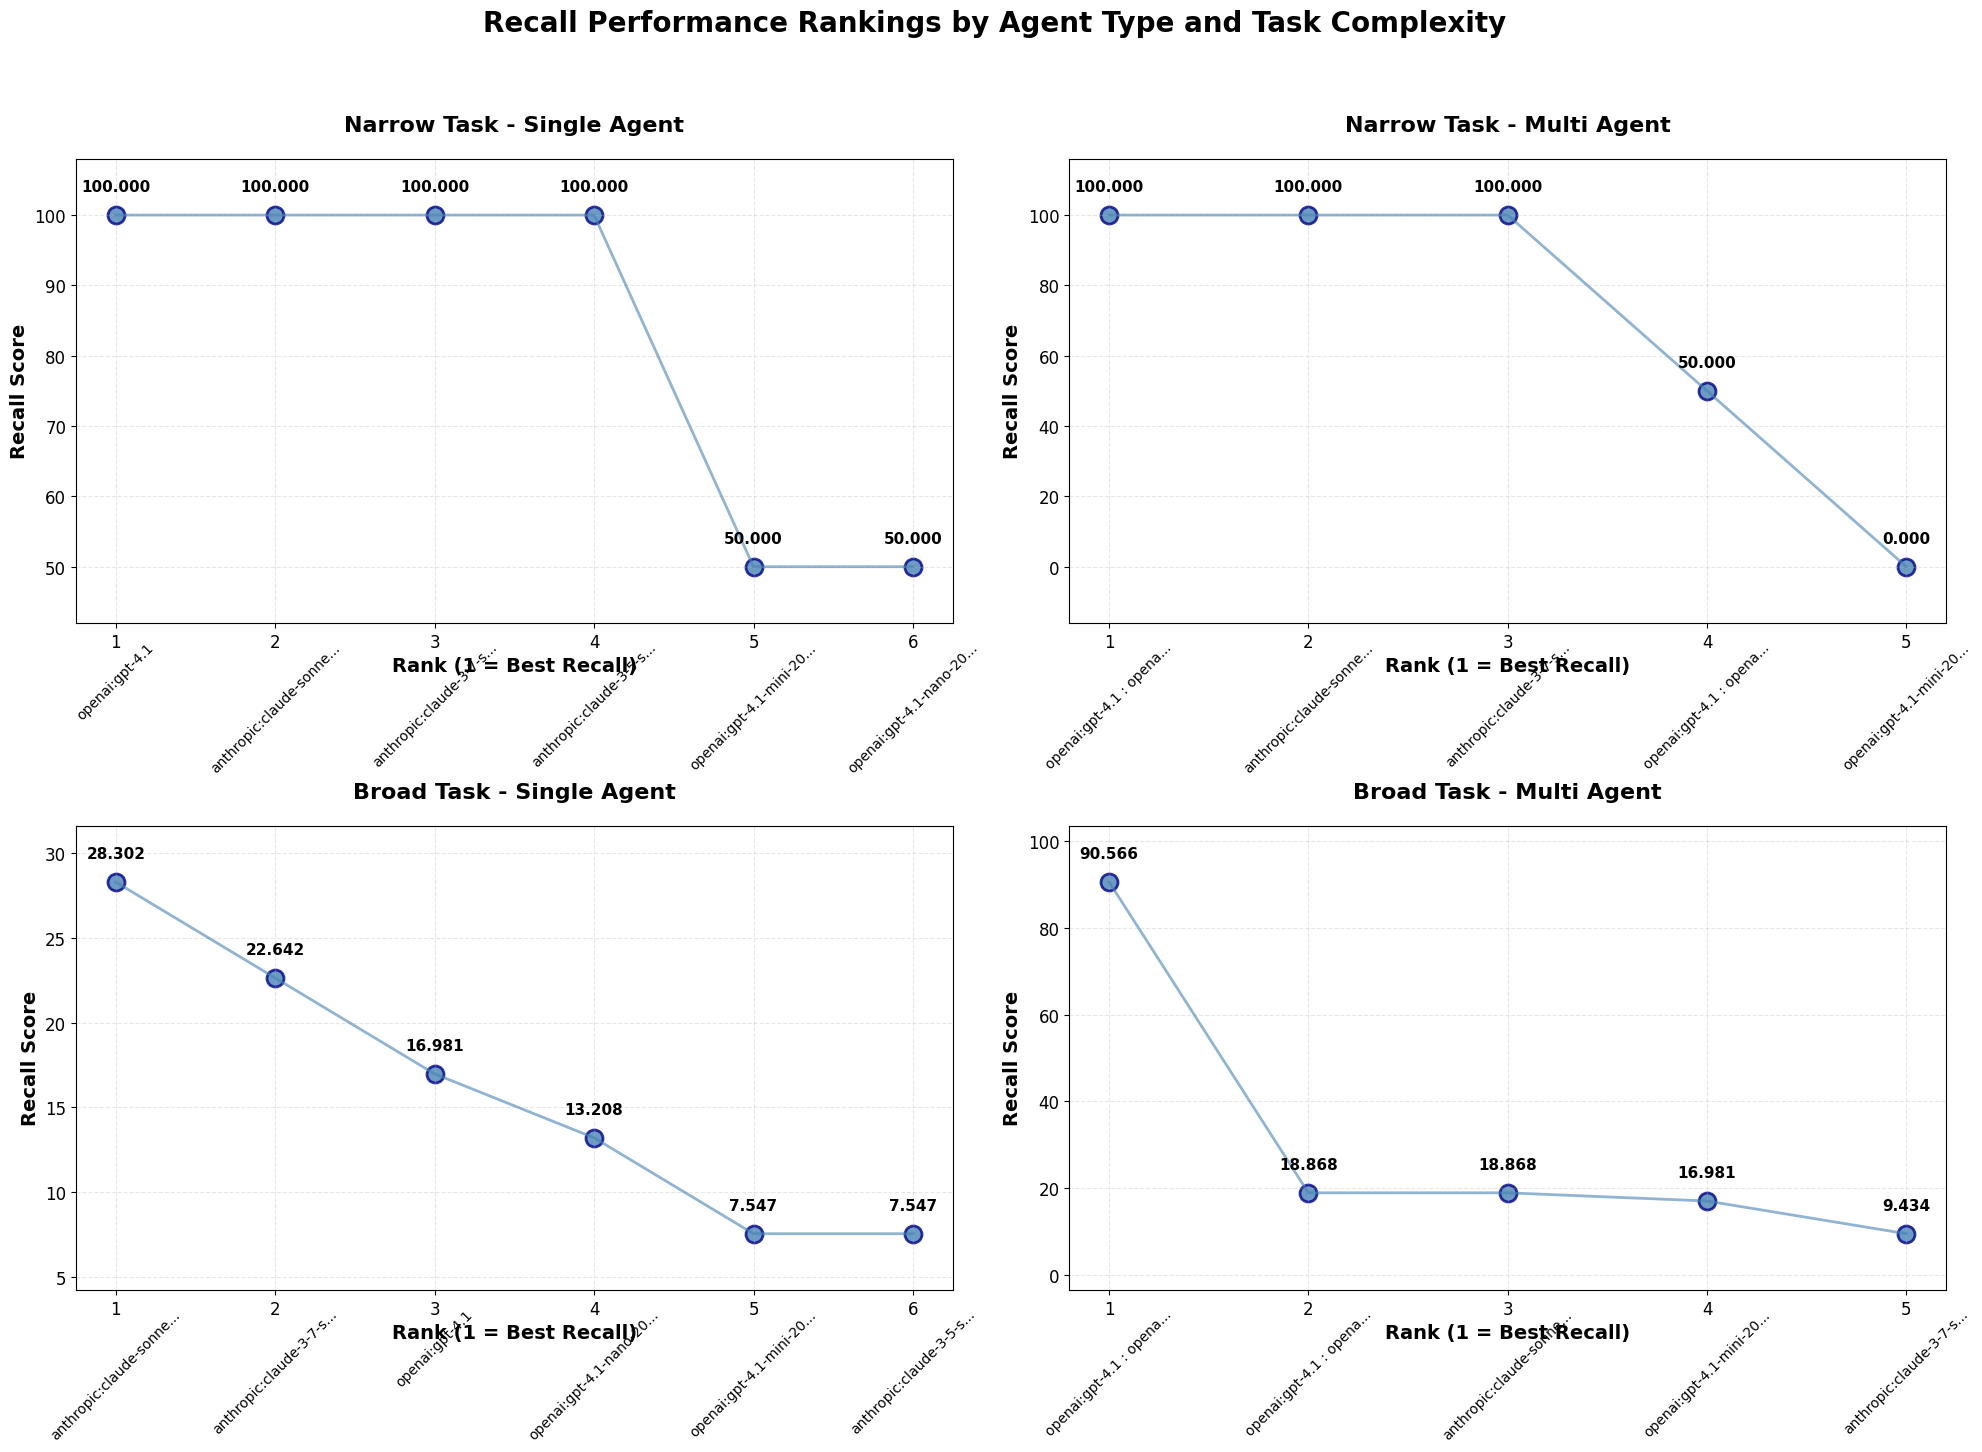

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def create_recall_ranking_plots(df):
    """
    Create a 2x2 grid of ordered point plots showing recall rankings for different agent types and tasks.

    Parameters:
    df (pd.DataFrame): DataFrame containing the evaluation results

    Returns:
    matplotlib.figure.Figure: The figure object containing the plots
    """

    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # Set overall style
    plt.style.use("default")
    sns.set_palette("husl")

    # Define the combinations for each subplot
    plot_configs = [
        {
            "task": "narrow",
            "agent_type": "single",
            "row": 0,
            "col": 0,
            "title": "Narrow Task - Single Agent",
        },
        {
            "task": "narrow",
            "agent_type": "multi",
            "row": 0,
            "col": 1,
            "title": "Narrow Task - Multi Agent",
        },
        {
            "task": "broad",
            "agent_type": "single",
            "row": 1,
            "col": 0,
            "title": "Broad Task - Single Agent",
        },
        {
            "task": "broad",
            "agent_type": "multi",
            "row": 1,
            "col": 1,
            "title": "Broad Task - Multi Agent",
        },
    ]

    for config in plot_configs:
        # Filter data for this specific combination
        subset = df[
            (df["task"] == config["task"]) & (df["agent_type"] == config["agent_type"])
        ]

        if len(subset) == 0:
            # Handle empty subset - show message
            ax = axes[config["row"], config["col"]]
            ax.text(
                0.5,
                0.5,
                f"No data available\nfor {config['title']}",
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=14,
            )
            ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Sort by recall (descending for ranking)
        subset_sorted = subset.sort_values("recall", ascending=False).reset_index(
            drop=True
        )

        # Create ranking (1 = best recall)
        subset_sorted["rank"] = range(1, len(subset_sorted) + 1)

        # Create the ordered point plot
        ax = axes[config["row"], config["col"]]

        # Plot the points
        ax.scatter(
            subset_sorted["rank"],
            subset_sorted["recall"],
            s=150,
            alpha=0.8,
            color="steelblue",
            edgecolors="darkblue",
            linewidth=2,
        )

        # Connect points with lines
        ax.plot(
            subset_sorted["rank"],
            subset_sorted["recall"],
            color="steelblue",
            alpha=0.6,
            linewidth=2,
            linestyle="-",
        )

        # Customize the plot
        ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
        ax.set_xlabel("Rank (1 = Best Recall)", fontsize=14, fontweight="bold")
        ax.set_ylabel("Recall Score", fontsize=14, fontweight="bold")

        # Set x-axis to show integer ranks
        ax.set_xticks(subset_sorted["rank"])
        ax.set_xticklabels(subset_sorted["rank"], fontsize=12)

        # Format y-axis
        ax.tick_params(axis="y", labelsize=12)
        ax.grid(True, alpha=0.3, linestyle="--")

        # Add value labels on points
        for i, row in subset_sorted.iterrows():
            ax.annotate(
                f"{row['recall']:.3f}",
                (row["rank"], row["recall"]),
                xytext=(0, 15),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=11,
                fontweight="bold",
            )

        # Add model name labels below x-axis
        for i, row in subset_sorted.iterrows():
            # Truncate long model names for better display
            model_name = row["main_model"]
            if len(model_name) > 25:
                model_name = model_name[:22] + "..."

            ax.annotate(
                model_name,
                (row["rank"], ax.get_ylim()[0]),
                xytext=(0, -40),
                textcoords="offset points",
                ha="center",
                va="top",
                fontsize=10,
                rotation=45,
            )

        # Adjust y-axis limits to accommodate labels
        y_min, y_max = ax.get_ylim()
        y_range = y_max - y_min
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    # Add overall title
    fig.suptitle(
        "Recall Performance Rankings by Agent Type and Task Complexity",
        fontsize=20,
        fontweight="bold",
        y=0.95,
    )

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])

    return fig


# Example usage function
def generate_recall_ranking_plots():
    """
    Generate the recall ranking plots using the evaluation data.
    Assumes the data files exist in the current directory.
    """
    # Load the data
    df_single_agent = pd.read_csv("./single_agent_results.csv")
    df_multi_agent = pd.read_csv("./multi_agent_results.csv")

    # Combine datasets
    df = pd.concat([df_single_agent, df_multi_agent])

    # Create main_model column
    df["main_model"] = df.apply(
        lambda row: f"{row['orchestrator_model']} : {row['researcher_model']}"
        if pd.notnull(row["orchestrator_model"])
        else row["researcher_model"],
        axis=1,
    )

    # Generate the plots
    fig = create_recall_ranking_plots(df)

    # Show the plots
    plt.show()

    return fig


fig = generate_recall_ranking_plots()

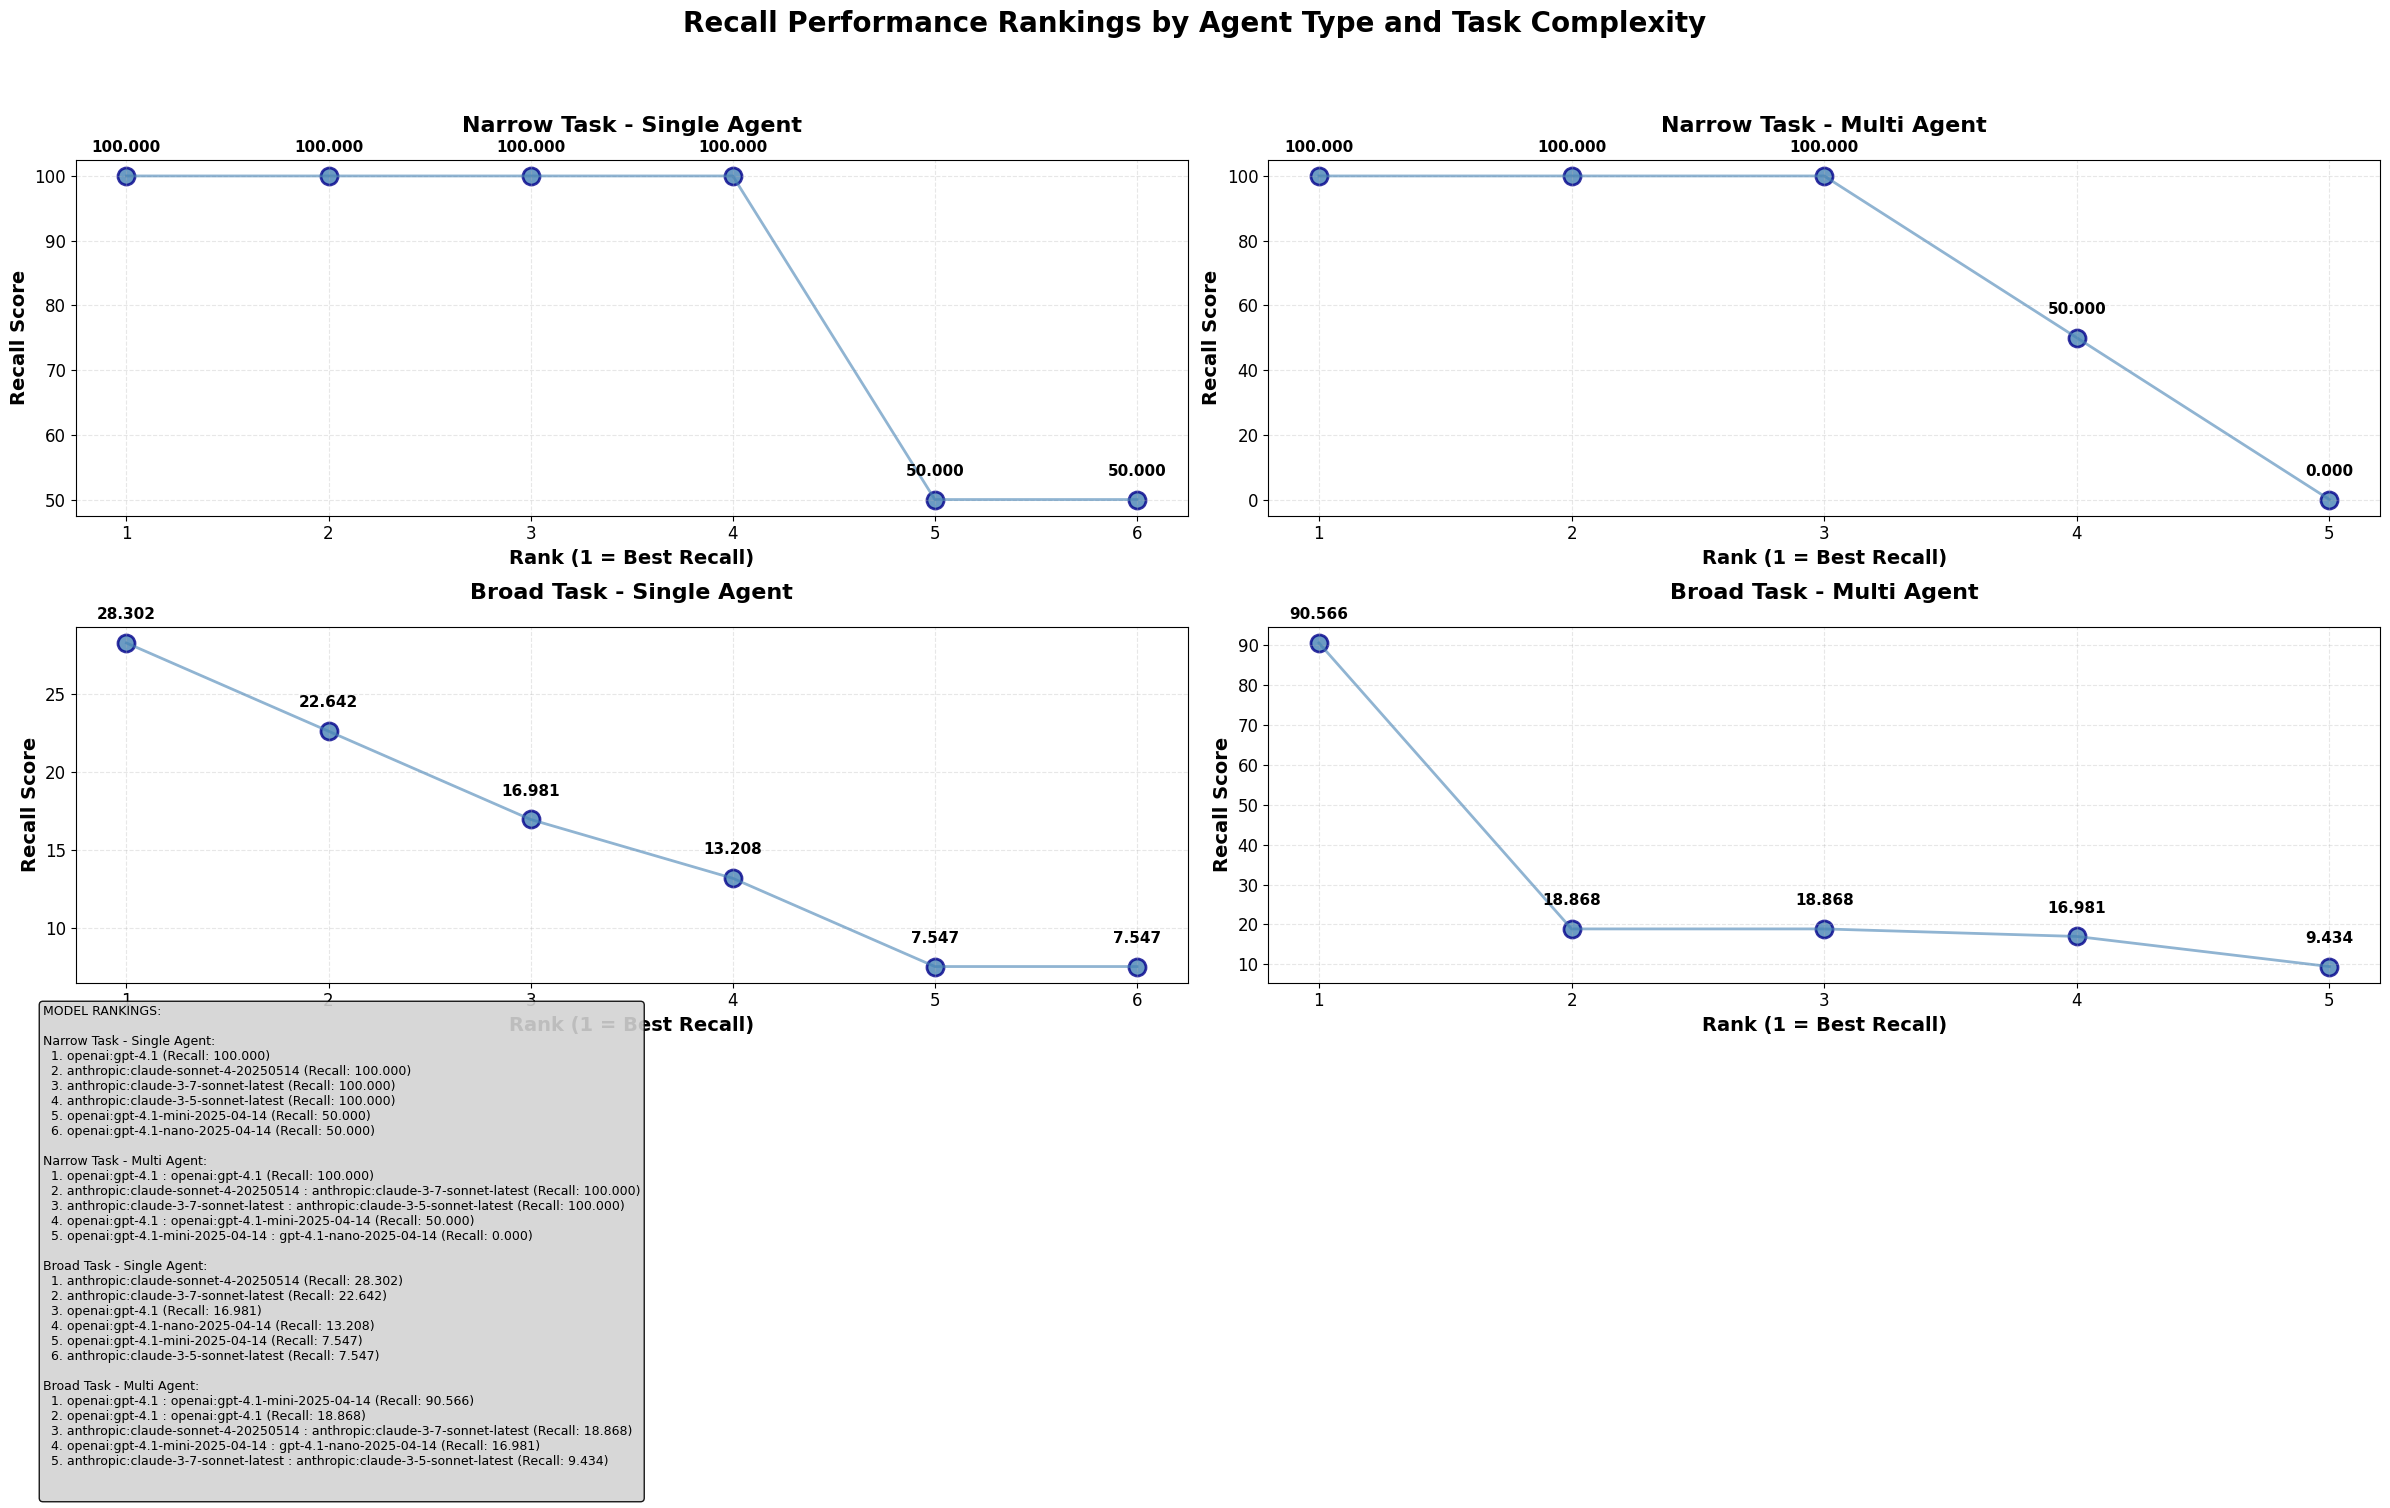

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def create_model_abbreviations(df):
    """Create shorter abbreviations for model names"""
    model_mapping = {}

    for model in df["main_model"].unique():
        if " : " in model:  # Multi-agent format
            parts = model.split(" : ")
            orch = parts[0].split(":")[-1] if ":" in parts[0] else parts[0]
            res = parts[1].split(":")[-1] if ":" in parts[1] else parts[1]

            # Create short abbreviations
            orch_short = (
                orch.replace("gpt-4.1", "GPT4.1")
                .replace("claude-", "C-")
                .replace("sonnet", "S")
                .replace("anthropic", "A")[:8]
            )
            res_short = (
                res.replace("gpt-4.1", "GPT4.1")
                .replace("claude-", "C-")
                .replace("sonnet", "S")
                .replace("anthropic", "A")[:8]
            )

            model_mapping[model] = f"{orch_short}:{res_short}"
        else:  # Single agent format
            short = model.split(":")[-1] if ":" in model else model
            short = (
                short.replace("gpt-4.1", "GPT4.1")
                .replace("claude-", "C-")
                .replace("sonnet", "S")
                .replace("anthropic", "A")
            )
            model_mapping[model] = short[:12]

    return model_mapping


def create_recall_ranking_plots_v2(df):
    """
    Create a 2x2 grid of ordered point plots with better x-axis label handling.
    """

    # Create model abbreviations
    model_mapping = create_model_abbreviations(df)

    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # Set overall style
    plt.style.use("default")
    sns.set_palette("husl")

    # Define the combinations for each subplot
    plot_configs = [
        {
            "task": "narrow",
            "agent_type": "single",
            "row": 0,
            "col": 0,
            "title": "Narrow Task - Single Agent",
        },
        {
            "task": "narrow",
            "agent_type": "multi",
            "row": 0,
            "col": 1,
            "title": "Narrow Task - Multi Agent",
        },
        {
            "task": "broad",
            "agent_type": "single",
            "row": 1,
            "col": 0,
            "title": "Broad Task - Single Agent",
        },
        {
            "task": "broad",
            "agent_type": "multi",
            "row": 1,
            "col": 1,
            "title": "Broad Task - Multi Agent",
        },
    ]

    # Create a legend mapping for all subplots
    legend_text = "Model Abbreviations:\n" + "\n".join(
        [f"{v}: {k}" for k, v in model_mapping.items()]
    )

    for config in plot_configs:
        # Filter data for this specific combination
        subset = df[
            (df["task"] == config["task"]) & (df["agent_type"] == config["agent_type"])
        ]

        if len(subset) == 0:
            # Handle empty subset - show message
            ax = axes[config["row"], config["col"]]
            ax.text(
                0.5,
                0.5,
                f"No data available\nfor {config['title']}",
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=14,
            )
            ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Sort by recall (descending for ranking)
        subset_sorted = subset.sort_values("recall", ascending=False).reset_index(
            drop=True
        )

        # Create ranking (1 = best recall)
        subset_sorted["rank"] = range(1, len(subset_sorted) + 1)

        # Create the ordered point plot
        ax = axes[config["row"], config["col"]]

        # Plot the points
        ax.scatter(
            subset_sorted["rank"],
            subset_sorted["recall"],
            s=150,
            alpha=0.8,
            color="steelblue",
            edgecolors="darkblue",
            linewidth=2,
        )

        # Connect points with lines
        ax.plot(
            subset_sorted["rank"],
            subset_sorted["recall"],
            color="steelblue",
            alpha=0.6,
            linewidth=2,
            linestyle="-",
        )

        # Customize the plot
        ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
        ax.set_xlabel("Rank (1 = Best Recall)", fontsize=14, fontweight="bold")
        ax.set_ylabel("Recall Score", fontsize=14, fontweight="bold")

        # Set x-axis to show integer ranks
        ax.set_xticks(subset_sorted["rank"])

        # Use abbreviated model names as x-axis labels
        abbreviated_names = [
            model_mapping[model] for model in subset_sorted["main_model"]
        ]
        ax.set_xticklabels(abbreviated_names, fontsize=10, rotation=45, ha="right")

        # Format y-axis
        ax.tick_params(axis="y", labelsize=12)
        ax.grid(True, alpha=0.3, linestyle="--")

        # Add value labels on points
        for i, row in subset_sorted.iterrows():
            ax.annotate(
                f"{row['recall']:.3f}",
                (row["rank"], row["recall"]),
                xytext=(0, 15),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=11,
                fontweight="bold",
            )

    # Add overall title
    fig.suptitle(
        "Recall Performance Rankings by Agent Type and Task Complexity",
        fontsize=20,
        fontweight="bold",
        y=0.95,
    )

    # Add legend with model mappings in a text box
    fig.text(
        0.02,
        0.02,
        legend_text,
        fontsize=8,
        verticalalignment="bottom",
        bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.8),
    )

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.15, 1, 0.92])

    return fig


# Alternative version with no x-axis labels, just numbers
def create_recall_ranking_plots_v3(df):
    """
    Create a 2x2 grid with numbered x-axis and a detailed legend table.
    """

    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(24, 16))

    # Set overall style
    plt.style.use("default")
    sns.set_palette("husl")

    # Define the combinations for each subplot
    plot_configs = [
        {
            "task": "narrow",
            "agent_type": "single",
            "row": 0,
            "col": 0,
            "title": "Narrow Task - Single Agent",
        },
        {
            "task": "narrow",
            "agent_type": "multi",
            "row": 0,
            "col": 1,
            "title": "Narrow Task - Multi Agent",
        },
        {
            "task": "broad",
            "agent_type": "single",
            "row": 1,
            "col": 0,
            "title": "Broad Task - Single Agent",
        },
        {
            "task": "broad",
            "agent_type": "multi",
            "row": 1,
            "col": 1,
            "title": "Broad Task - Multi Agent",
        },
    ]

    # Store legend information for each subplot
    legend_info = {}

    for config in plot_configs:
        # Filter data for this specific combination
        subset = df[
            (df["task"] == config["task"]) & (df["agent_type"] == config["agent_type"])
        ]

        if len(subset) == 0:
            # Handle empty subset - show message
            ax = axes[config["row"], config["col"]]
            ax.text(
                0.5,
                0.5,
                f"No data available\nfor {config['title']}",
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=14,
            )
            ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Sort by recall (descending for ranking)
        subset_sorted = subset.sort_values("recall", ascending=False).reset_index(
            drop=True
        )

        # Create ranking (1 = best recall)
        subset_sorted["rank"] = range(1, len(subset_sorted) + 1)

        # Store legend info
        legend_info[config["title"]] = list(
            zip(
                subset_sorted["rank"],
                subset_sorted["main_model"],
                subset_sorted["recall"],
            )
        )

        # Create the ordered point plot
        ax = axes[config["row"], config["col"]]

        # Plot the points
        ax.scatter(
            subset_sorted["rank"],
            subset_sorted["recall"],
            s=150,
            alpha=0.8,
            color="steelblue",
            edgecolors="darkblue",
            linewidth=2,
        )

        # Connect points with lines
        ax.plot(
            subset_sorted["rank"],
            subset_sorted["recall"],
            color="steelblue",
            alpha=0.6,
            linewidth=2,
            linestyle="-",
        )

        # Customize the plot
        ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
        ax.set_xlabel("Rank (1 = Best Recall)", fontsize=14, fontweight="bold")
        ax.set_ylabel("Recall Score", fontsize=14, fontweight="bold")

        # Set x-axis to show integer ranks only
        ax.set_xticks(subset_sorted["rank"])
        ax.set_xticklabels(subset_sorted["rank"], fontsize=12)

        # Format y-axis
        ax.tick_params(axis="y", labelsize=12)
        ax.grid(True, alpha=0.3, linestyle="--")

        # Add value labels on points
        for i, row in subset_sorted.iterrows():
            ax.annotate(
                f"{row['recall']:.3f}",
                (row["rank"], row["recall"]),
                xytext=(0, 15),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=11,
                fontweight="bold",
            )

    # Add overall title
    fig.suptitle(
        "Recall Performance Rankings by Agent Type and Task Complexity",
        fontsize=20,
        fontweight="bold",
        y=0.95,
    )

    # Create a detailed legend table
    legend_text = "MODEL RANKINGS:\n\n"
    for title, info in legend_info.items():
        legend_text += f"{title}:\n"
        for rank, model, recall in info:
            legend_text += f"  {rank}. {model} (Recall: {recall:.3f})\n"
        legend_text += "\n"

    # Add legend as text box
    fig.text(
        0.02,
        0.02,
        legend_text,
        fontsize=9,
        verticalalignment="bottom",
        bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.9),
    )

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.3, 1, 0.92])

    return fig


# Updated main function with options
def generate_recall_ranking_plots(version="v2"):
    """
    Generate the recall ranking plots using the evaluation data.

    Parameters:
    version (str): "v2" for abbreviated labels, "v3" for numbered ranks with legend
    """
    # Load the data
    df_single_agent = pd.read_csv("./single_agent_results.csv")
    df_multi_agent = pd.read_csv("./multi_agent_results.csv")

    # Combine datasets
    df = pd.concat([df_single_agent, df_multi_agent])

    # Create main_model column
    df["main_model"] = df.apply(
        lambda row: f"{row['orchestrator_model']} : {row['researcher_model']}"
        if pd.notnull(row["orchestrator_model"])
        else row["researcher_model"],
        axis=1,
    )

    # Generate the plots based on version
    if version == "v3":
        fig = create_recall_ranking_plots_v3(df)
    else:
        fig = create_recall_ranking_plots_v2(df)

    # Show the plots
    plt.show()

    return fig


# For numbered ranks with legend version
fig = generate_recall_ranking_plots(version="v3")

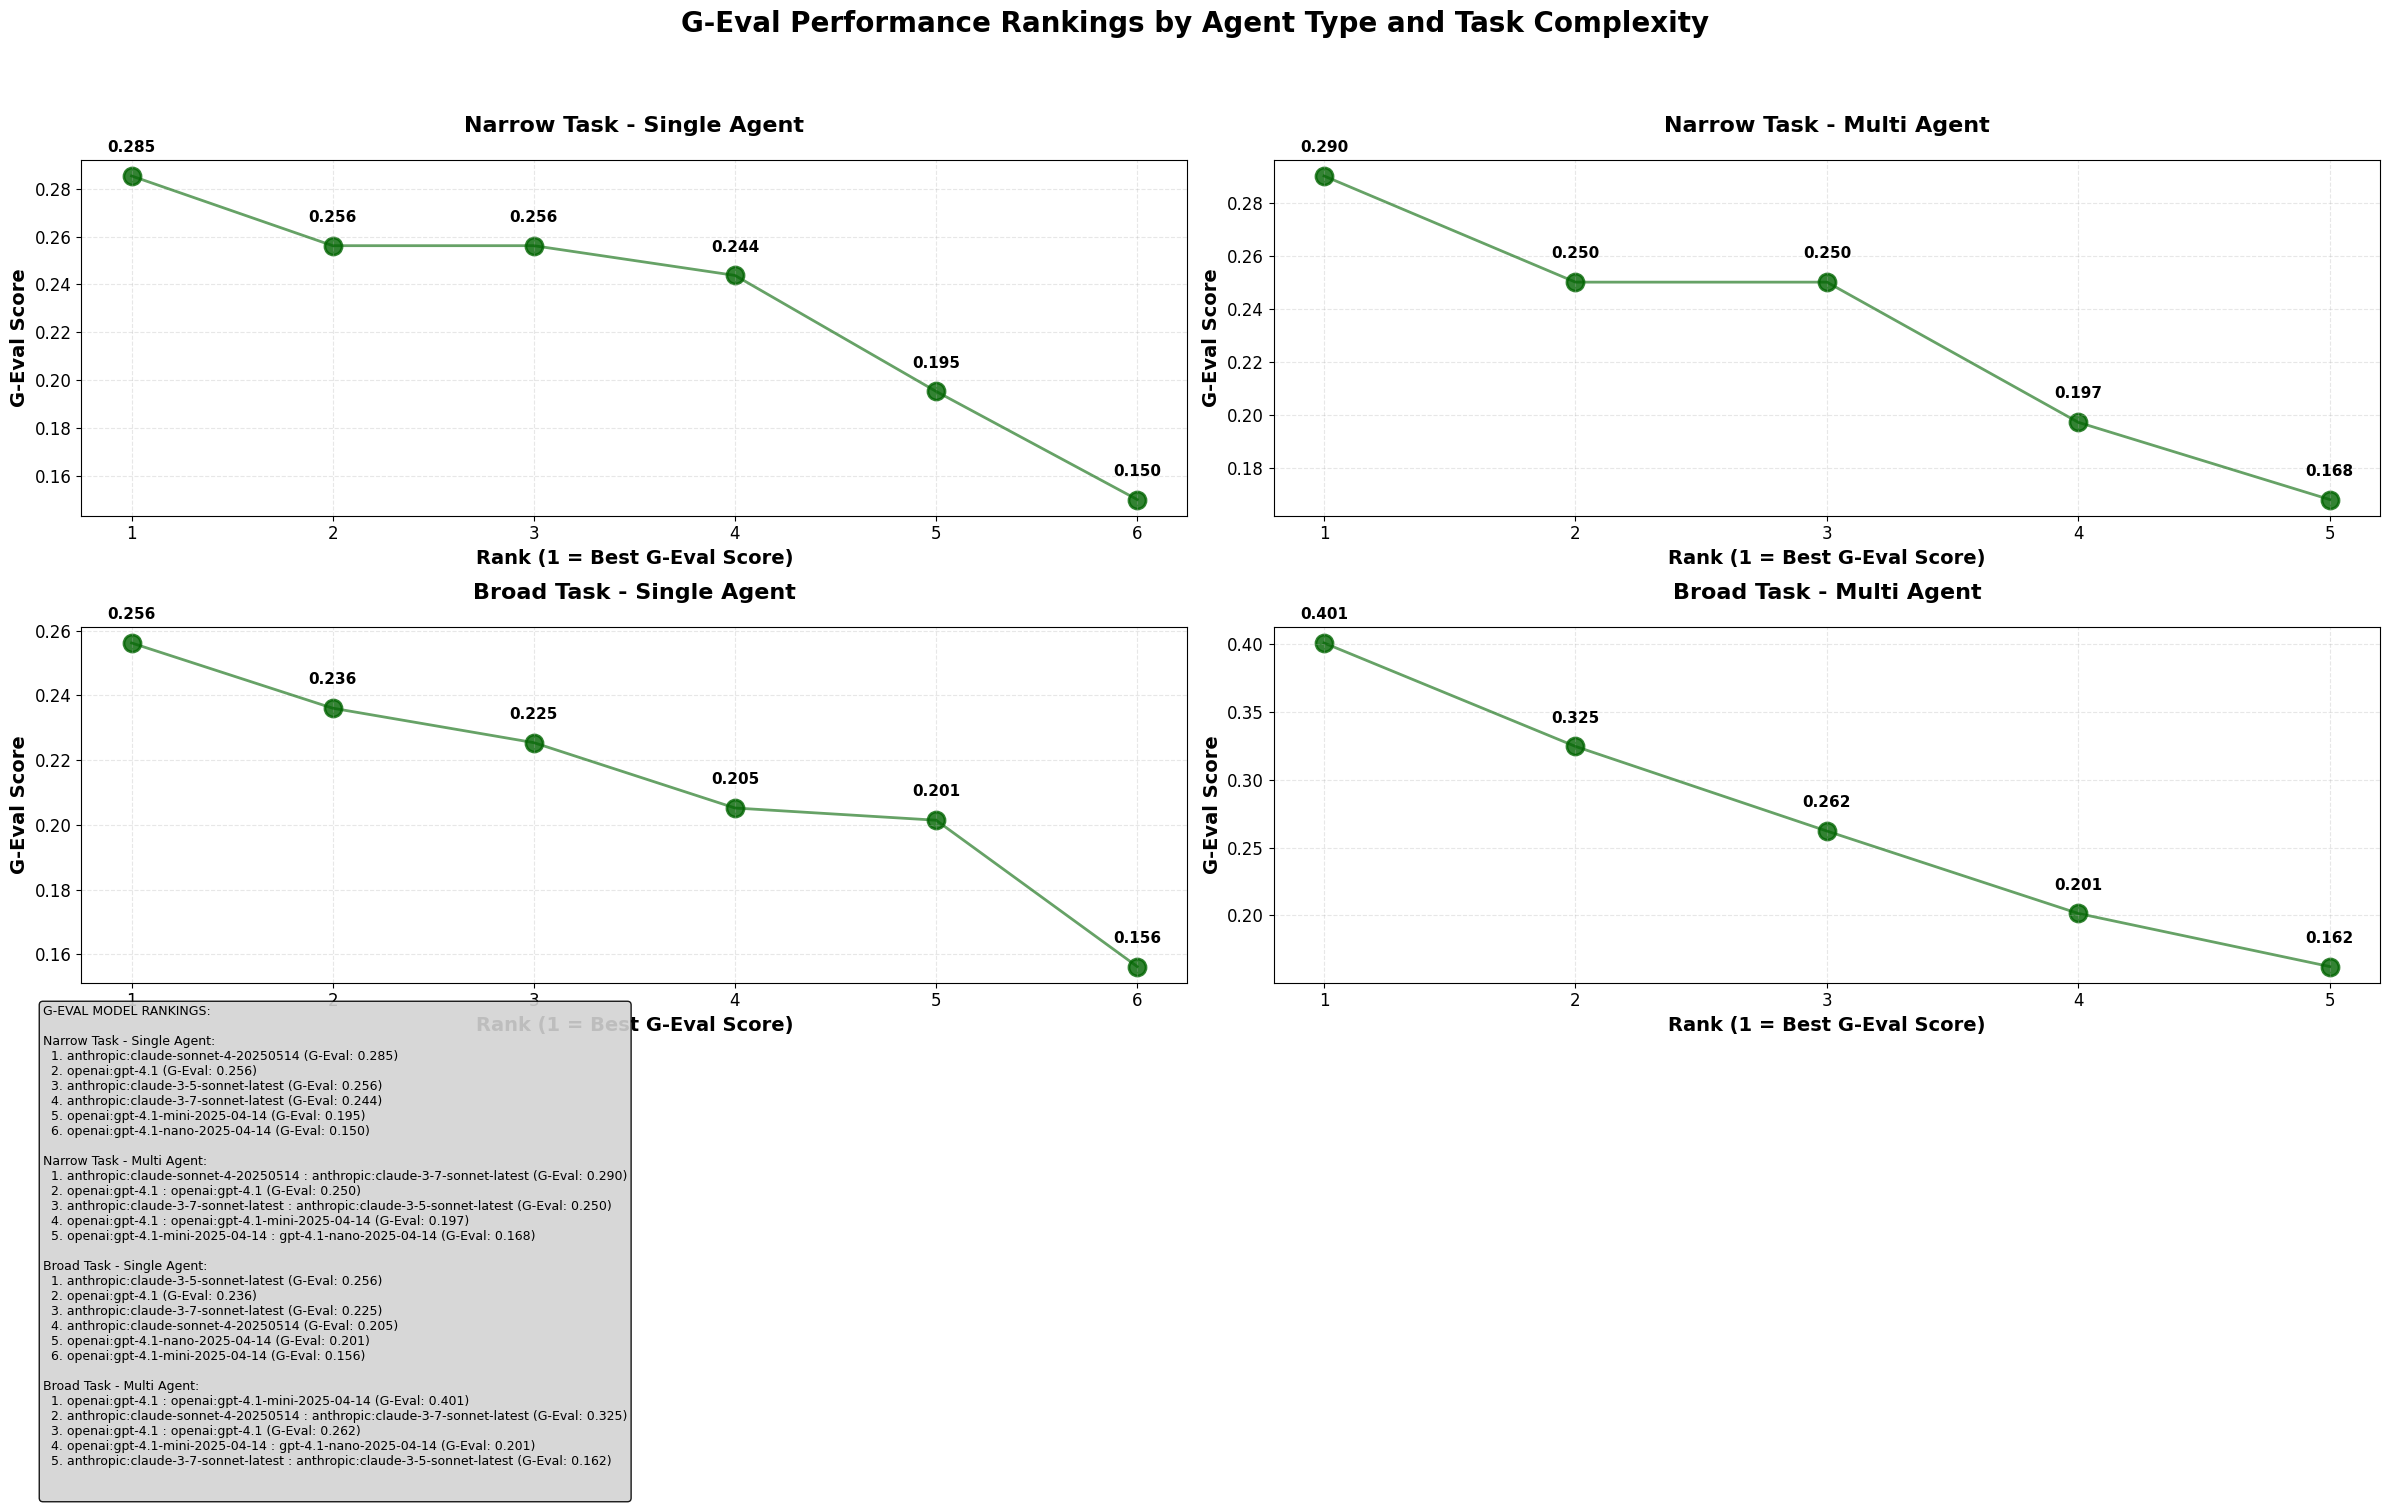

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def create_model_abbreviations(df):
    """Create shorter abbreviations for model names"""
    model_mapping = {}

    for model in df["main_model"].unique():
        if " : " in model:  # Multi-agent format
            parts = model.split(" : ")
            orch = parts[0].split(":")[-1] if ":" in parts[0] else parts[0]
            res = parts[1].split(":")[-1] if ":" in parts[1] else parts[1]

            # Create short abbreviations
            orch_short = (
                orch.replace("gpt-4.1", "GPT4.1")
                .replace("claude-", "C-")
                .replace("sonnet", "S")
                .replace("anthropic", "A")[:8]
            )
            res_short = (
                res.replace("gpt-4.1", "GPT4.1")
                .replace("claude-", "C-")
                .replace("sonnet", "S")
                .replace("anthropic", "A")[:8]
            )

            model_mapping[model] = f"{orch_short}:{res_short}"
        else:  # Single agent format
            short = model.split(":")[-1] if ":" in model else model
            short = (
                short.replace("gpt-4.1", "GPT4.1")
                .replace("claude-", "C-")
                .replace("sonnet", "S")
                .replace("anthropic", "A")
            )
            model_mapping[model] = short[:12]

    return model_mapping


def create_geval_ranking_plots_v2(df):
    """
    Create a 2x2 grid of ordered point plots with G-Eval rankings and abbreviated labels.
    """

    # Create model abbreviations
    model_mapping = create_model_abbreviations(df)

    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # Set overall style
    plt.style.use("default")
    sns.set_palette("husl")

    # Define the combinations for each subplot
    plot_configs = [
        {
            "task": "narrow",
            "agent_type": "single",
            "row": 0,
            "col": 0,
            "title": "Narrow Task - Single Agent",
        },
        {
            "task": "narrow",
            "agent_type": "multi",
            "row": 0,
            "col": 1,
            "title": "Narrow Task - Multi Agent",
        },
        {
            "task": "broad",
            "agent_type": "single",
            "row": 1,
            "col": 0,
            "title": "Broad Task - Single Agent",
        },
        {
            "task": "broad",
            "agent_type": "multi",
            "row": 1,
            "col": 1,
            "title": "Broad Task - Multi Agent",
        },
    ]

    # Create a legend mapping for all subplots
    legend_text = "Model Abbreviations:\n" + "\n".join(
        [f"{v}: {k}" for k, v in model_mapping.items()]
    )

    for config in plot_configs:
        # Filter data for this specific combination
        subset = df[
            (df["task"] == config["task"]) & (df["agent_type"] == config["agent_type"])
        ]

        if len(subset) == 0:
            # Handle empty subset - show message
            ax = axes[config["row"], config["col"]]
            ax.text(
                0.5,
                0.5,
                f"No data available\nfor {config['title']}",
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=14,
            )
            ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Sort by g_eval (descending for ranking) - handle NaN values
        subset_clean = subset.dropna(subset=["g_eval"])
        if len(subset_clean) == 0:
            ax = axes[config["row"], config["col"]]
            ax.text(
                0.5,
                0.5,
                f"No G-Eval data available\nfor {config['title']}",
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=14,
            )
            ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        subset_sorted = subset_clean.sort_values("g_eval", ascending=False).reset_index(
            drop=True
        )

        # Create ranking (1 = best g_eval)
        subset_sorted["rank"] = range(1, len(subset_sorted) + 1)

        # Create the ordered point plot
        ax = axes[config["row"], config["col"]]

        # Plot the points
        ax.scatter(
            subset_sorted["rank"],
            subset_sorted["g_eval"],
            s=150,
            alpha=0.8,
            color="darkgreen",
            edgecolors="darkgreen",
            linewidth=2,
        )

        # Connect points with lines
        ax.plot(
            subset_sorted["rank"],
            subset_sorted["g_eval"],
            color="darkgreen",
            alpha=0.6,
            linewidth=2,
            linestyle="-",
        )

        # Customize the plot
        ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
        ax.set_xlabel("Rank (1 = Best G-Eval Score)", fontsize=14, fontweight="bold")
        ax.set_ylabel("G-Eval Score", fontsize=14, fontweight="bold")

        # Set x-axis to show integer ranks
        ax.set_xticks(subset_sorted["rank"])

        # Use abbreviated model names as x-axis labels
        abbreviated_names = [
            model_mapping[model] for model in subset_sorted["main_model"]
        ]
        ax.set_xticklabels(abbreviated_names, fontsize=10, rotation=45, ha="right")

        # Format y-axis
        ax.tick_params(axis="y", labelsize=12)
        ax.grid(True, alpha=0.3, linestyle="--")

        # Add value labels on points
        for i, row in subset_sorted.iterrows():
            ax.annotate(
                f"{row['g_eval']:.3f}",
                (row["rank"], row["g_eval"]),
                xytext=(0, 15),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=11,
                fontweight="bold",
            )

    # Add overall title
    fig.suptitle(
        "G-Eval Performance Rankings by Agent Type and Task Complexity",
        fontsize=20,
        fontweight="bold",
        y=0.95,
    )

    # Add legend with model mappings in a text box
    fig.text(
        0.02,
        0.02,
        legend_text,
        fontsize=8,
        verticalalignment="bottom",
        bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.8),
    )

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.15, 1, 0.92])

    return fig


def create_geval_ranking_plots_v3(df):
    """
    Create a 2x2 grid with numbered x-axis and a detailed legend table for G-Eval scores.
    """

    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(24, 16))

    # Set overall style
    plt.style.use("default")
    sns.set_palette("husl")

    # Define the combinations for each subplot
    plot_configs = [
        {
            "task": "narrow",
            "agent_type": "single",
            "row": 0,
            "col": 0,
            "title": "Narrow Task - Single Agent",
        },
        {
            "task": "narrow",
            "agent_type": "multi",
            "row": 0,
            "col": 1,
            "title": "Narrow Task - Multi Agent",
        },
        {
            "task": "broad",
            "agent_type": "single",
            "row": 1,
            "col": 0,
            "title": "Broad Task - Single Agent",
        },
        {
            "task": "broad",
            "agent_type": "multi",
            "row": 1,
            "col": 1,
            "title": "Broad Task - Multi Agent",
        },
    ]

    # Store legend information for each subplot
    legend_info = {}

    for config in plot_configs:
        # Filter data for this specific combination
        subset = df[
            (df["task"] == config["task"]) & (df["agent_type"] == config["agent_type"])
        ]

        if len(subset) == 0:
            # Handle empty subset - show message
            ax = axes[config["row"], config["col"]]
            ax.text(
                0.5,
                0.5,
                f"No data available\nfor {config['title']}",
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=14,
            )
            ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Sort by g_eval (descending for ranking) - handle NaN values
        subset_clean = subset.dropna(subset=["g_eval"])
        if len(subset_clean) == 0:
            ax = axes[config["row"], config["col"]]
            ax.text(
                0.5,
                0.5,
                f"No G-Eval data available\nfor {config['title']}",
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=14,
            )
            ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks([])
            ax.set_yticks([])
            legend_info[config["title"]] = []
            continue

        subset_sorted = subset_clean.sort_values("g_eval", ascending=False).reset_index(
            drop=True
        )

        # Create ranking (1 = best g_eval)
        subset_sorted["rank"] = range(1, len(subset_sorted) + 1)

        # Store legend info
        legend_info[config["title"]] = list(
            zip(
                subset_sorted["rank"],
                subset_sorted["main_model"],
                subset_sorted["g_eval"],
            )
        )

        # Create the ordered point plot
        ax = axes[config["row"], config["col"]]

        # Plot the points
        ax.scatter(
            subset_sorted["rank"],
            subset_sorted["g_eval"],
            s=150,
            alpha=0.8,
            color="darkgreen",
            edgecolors="darkgreen",
            linewidth=2,
        )

        # Connect points with lines
        ax.plot(
            subset_sorted["rank"],
            subset_sorted["g_eval"],
            color="darkgreen",
            alpha=0.6,
            linewidth=2,
            linestyle="-",
        )

        # Customize the plot
        ax.set_title(config["title"], fontsize=16, fontweight="bold", pad=20)
        ax.set_xlabel("Rank (1 = Best G-Eval Score)", fontsize=14, fontweight="bold")
        ax.set_ylabel("G-Eval Score", fontsize=14, fontweight="bold")

        # Set x-axis to show integer ranks only
        ax.set_xticks(subset_sorted["rank"])
        ax.set_xticklabels(subset_sorted["rank"], fontsize=12)

        # Format y-axis
        ax.tick_params(axis="y", labelsize=12)
        ax.grid(True, alpha=0.3, linestyle="--")

        # Add value labels on points
        for i, row in subset_sorted.iterrows():
            ax.annotate(
                f"{row['g_eval']:.3f}",
                (row["rank"], row["g_eval"]),
                xytext=(0, 15),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=11,
                fontweight="bold",
            )

    # Add overall title
    fig.suptitle(
        "G-Eval Performance Rankings by Agent Type and Task Complexity",
        fontsize=20,
        fontweight="bold",
        y=0.95,
    )

    # Create a detailed legend table
    legend_text = "G-EVAL MODEL RANKINGS:\n\n"
    for title, info in legend_info.items():
        legend_text += f"{title}:\n"
        if len(info) == 0:
            legend_text += "  No data available\n"
        else:
            for rank, model, g_eval in info:
                legend_text += f"  {rank}. {model} (G-Eval: {g_eval:.3f})\n"
        legend_text += "\n"

    # Add legend as text box
    fig.text(
        0.02,
        0.02,
        legend_text,
        fontsize=9,
        verticalalignment="bottom",
        bbox=dict(boxstyle="round", facecolor="lightgray", alpha=0.9),
    )

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.3, 1, 0.92])

    return fig


# Main function for G-Eval plots
def generate_geval_ranking_plots(version="v3"):
    """
    Generate the G-Eval ranking plots using the evaluation data.

    Parameters:
    version (str): "v2" for abbreviated labels, "v3" for numbered ranks with legend
    """
    # Load the data
    df_single_agent = pd.read_csv("./single_agent_results.csv")
    df_multi_agent = pd.read_csv("./multi_agent_results.csv")

    # Combine datasets
    df = pd.concat([df_single_agent, df_multi_agent])

    # Create main_model column
    df["main_model"] = df.apply(
        lambda row: f"{row['orchestrator_model']} : {row['researcher_model']}"
        if pd.notnull(row["orchestrator_model"])
        else row["researcher_model"],
        axis=1,
    )

    # Generate the plots based on version
    if version == "v3":
        fig = create_geval_ranking_plots_v3(df)
    else:
        fig = create_geval_ranking_plots_v2(df)

    # Show the plots
    plt.show()

    return fig


# For numbered ranks with legend version (recommended)
fig = generate_geval_ranking_plots(version="v3")